In [1]:
"""
Database exists: Nights spent at tourist accommodation establishments by degree of urbanisation (from 2012 onwards) (tour_occ_ninatd)
Weather data?:
    https://climate.copernicus.eu/monthly-summaries-precipitation-relative-humidity-and-soil-moisture
    https://climate.copernicus.eu/node/74
"""
pass

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_management import load_tsv
from data_utils import string_encoding_to_datetime, select_by_dict, get_df_with_split_time, print_unique_values
from datetime import datetime
plt.rcParams['figure.figsize'] = 20, 16

In [3]:
class FeatureExclusionManager(object):
    def __init__(self):
        self.store_loc = "data_store/excluded_features.txt"
        self.delimiter = ":::"
    
    def get(self):
        with open(self.store_loc, "r") as file:
            excluded = file.read().split(self.delimiter)
        return excluded
    
    def save(self, additions):
        new_list = self.get() + additions
        new_list = list(set(new_list))
        
        with open(self.store_loc, "w") as file:
            file.write(self.delimiter.join(new_list))
FEM = FeatureExclusionManager()

In [15]:
YEAR_BOUNDS = (1998, 2018)
PREDICTION_TIME_SCALE = "month"
def extrapolate_time(inp_df, kind=PREDICTION_TIME_SCALE, year_bounds = YEAR_BOUNDS):
    def __sub(sub_df):
        df = sub_df.copy()
        df.drop_duplicates(inplace=True, keep = "last", subset=[col for col in df.columns if col != "value"])
        df["time"] = df["time"].apply(string_encoding_to_datetime)

        if kind == "year":
            indices = [datetime(y, 1, 1) for y in range(YEAR_BOUNDS[0], YEAR_BOUNDS[1]+1)]
        elif kind == "month":
            indices = [
                datetime(y, m, 1) for y in range(YEAR_BOUNDS[0], YEAR_BOUNDS[1]+1) for m in range (1,12+1)
            ]

        res = pd.DataFrame(columns = df.columns)
        res = res.set_index("time")
        for geo in df["geo"].unique():
            interpolated = pd.DataFrame(df[df["geo"] == geo].set_index("time"), index=indices)
            interpolated = interpolated.interpolate(method='time', limit_direction="both")
            interpolated["geo"] = geo
            res = res.append(interpolated)
        return res.rename_axis('time').reset_index()
    extra_columns = [col for col in inp_df.columns if col not in ["time", "geo", "value"]]
    if len(extra_columns) == 0:
        return __sub(inp_df)
    else:
        res = pd.DataFrame(columns = inp_df.columns)
        groups = inp_df.groupby(extra_columns)
        for group in groups.groups:
            temp = __sub(groups.get_group(group))
            for col in extra_columns:
                temp[col] = group[col] if len(extra_columns) > 1 else group
            res.append(temp)
        return temp
        
# extrapolate_time(select_by_dict(lan_settl, {
#     "unit": "Percentage"
# }), "month")
# extrapolate_time(lan_settl, "month")

"""
Inputs format:
    dict_of_parameters = {
            "name": {
                "source": dataframe,
                "fields": {
                    "name": [list of accepted values] OR expected value OR "ALL" OR "ALL - somthing"
                },
                "fillna": value #Optional
        },
    The other inputs are the same as extrapolate_time
    If feature in the the list of excluded features, it is ignored
"""
def join_and_extrapolate_values_from_multiple_sources(dict_of_parameters, kind=PREDICTION_TIME_SCALE, year_bounds = YEAR_BOUNDS):
    final_df = None
    excluded_features = FEM.get()
    
    for name, df_parameters in dict_of_parameters.items():
        source = df_parameters["source"]
        fields_parameters = df_parameters["fields"]
        
        # Filter only to wanted values
        for field_name, accepted_values in fields_parameters.items():
            if isinstance(accepted_values, list):
                source = source[source[field_name].isin(accepted_values)]
            elif accepted_values == "ALL":
                continue
            elif accepted_values.startswith("ALL - "):
                rejected_value = accepted_values.replace("ALL - ", "")
                source = source[source[field_name] != rejected_value] 
            else:
                source = source[source[field_name] == accepted_values]
        
        unqiue_field_combinations = source[fields_parameters.keys()].drop_duplicates()
        for index, row in unqiue_field_combinations.iterrows():
            identifier = name + ": " + "; ".join([str(r) for r in row.values])
            filtered_df = select_by_dict(source, row.to_dict())
            filtered_df = extrapolate_time(filtered_df, kind, year_bounds)
            filtered_df = filtered_df.set_index(["geo", "time"])
            
            if final_df is None:
                final_df = pd.DataFrame(index=filtered_df.index)
            final_df[identifier] = filtered_df["value"]
    
    fillna_dict = {}
    for name, df_parameters in dict_of_parameters.items():
        fillna = df_parameters.get("fillna", None)
        if fillna is not None:
            for col in [col for col in final_df.columns if col.startswith(name + ": ")]:
                fillna_dict[col] = fillna
    
    final_df = final_df.fillna(fillna_dict)
    final_df = final_df[[col for col in final_df.columns if col not in excluded_features]]
    return final_df

In [16]:
# Nights spent at tourist accommodation establishments - monthly data
nights_spent = load_tsv("tour_occ_nim.tsv", decode=True)
nights_spent["value"] = nights_spent["value"].astype(float)
sub = get_df_with_split_time(select_by_dict(nights_spent, {
    "c_resid": "Foreign country",
    "unit": "Number",
    "nace_r2": "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks"
}))
sub["value"] = sub["value"] / sub.groupby(['geo', "year"])["value"].transform(np.sum)
sub

,geo,value,year,month
41,Albania,NaN,2019,12
42,Austria,NaN,2019,12
43,Belgium,NaN,2019,12
44,Bulgaria,NaN,2019,12
45,Switzerland,NaN,2019,12
...,...,...,...,...
426568,Sweden,0.045302,1990,1
426569,Slovenia,NaN,1990,1
426570,Slovakia,NaN,1990,1
426571,United Kingdom,NaN,1990,1


In [17]:
"""
Feature databases
Land cover overview by NUTS 2 regions (lan_lcv_ovw)
    unit:
        Percentage
    landcover:
        ALL
Settlement area (lan_settl)
    unit:
        Square metres per capita
        Percentage
Distribution of population aged 18 and over by health status, age group, sex and degree of urbanisation - EU-SILC survey (ilc_lvhl01)
    deg_urb:
        ALL - Total
    levels:
        ALL
    age:
        ALL
    sex:
        Females
        Males
Mean and median income by degree of urbanisation (ilc_di17)
    unit:
        Purchasing power standard
    indic_il:
        Median equivalised net income
        Mean equivalised net income
    deg_urb:
        ALL
    sex:
        Females
        Males
    age:
        ALL - Total
Persons working as creative and performing artists, authors, journalists and linguists by individual and employment characteristics (cult_emp_artpc)
    unit:
        Percentage
    isco08:
        ALL
    ind_type:
        ALL
General government expenditure by function (COFOG) (gov_10a_exp)
    NOTE: THIS ONE IS BIG
Prisoners by age and sex - number and rate for the relevant sex and age groups (crim_pris_age)
    age:
        Adult
        Juvenile
    sex
        Females
        Males
    unit
        Per hundred thousand inhabitants
"""
tour_occ_nim = load_tsv("tour_occ_nim.tsv", decode=True)
lan_lcv_ovw = load_tsv("lan_lcv_ovw.tsv", decode=True)
lan_settl = load_tsv("lan_settl.tsv", decode=True)
ilc_lvhl01 = load_tsv("ilc_lvhl01.tsv", decode=True)
ilc_di17 = load_tsv("ilc_di17.tsv", decode=True)
cult_emp_artpc = load_tsv("cult_emp_artpc.tsv", decode=True)
# gov_10a_exp = load_tsv("gov_10a_exp.tsv", decode=True)
crim_pris_age = load_tsv("crim_pris_age.tsv", decode=True)

# Regional has too many regions
lan_lcv_ovw = lan_lcv_ovw[lan_lcv_ovw["geo"].isin(lan_settl["geo"])]

In [18]:
print_unique_values(lan_lcv_ovw)

unit
	Coefficient of variation for absolute value
	Square kilometre
	Percentage
landcover
	Artificial land
	Built-up areas
	Buildings with 1 to 3 floors
	Buildings with more than 3 floors
	Greenhouses
	Artificial non built-up areas
	Non built-up area features
	Non built-up linear features
	Other artificial areas
	Cropland
	Cereals
	Common wheat
	Durum wheat
	Barley
	Rye
	Oats
	Maize
	Rice
	Triticale
	Other cereals
	Root crops
	Potatoes
	Sugar beet
	Other root crops
	Non permanent industrial crops
	Sunflower
	Rape and turnip seeds
	Soya
	Cotton
	Other fibre and oleaginous crops
	Tobacco
	Other non permanent industrial crops
	Dry pulses, vegetables and flowers
	Dry pulses
	Tomatoes
	Other fresh vegetables
	Floriculture and ornamental plants
	Strawberries
	Fodder crops (mainly leguminous)
	Clovers
	Lucerne
	Other legumes and mixture for fodder
	Mixed cereals for fodder
	Temporary grassland
	Fruit trees and berries
	Apple fruit
	Pear fruit
	Cherry fruit
	Nuts trees
	Other fruit trees and b

In [19]:
temp = join_and_extrapolate_values_from_multiple_sources({
#     "nights_stayed": {
#         "source": tour_occ_nim,
#         "fields": {
#             "c_resid": "ALL - Total",
#             "unit": "ALL",
#             "nace_r2": "ALL",
#         },
#         "fillna": 0
#     },
    "land_cover" : {
        "source": lan_lcv_ovw,
        "fields": {
            "unit": "ALL",
            "landcover": "ALL",
        },
        "fillna": 0
    },
    "set_area" : {
        "source": lan_settl,
        "fields": {
            "unit": ["Square metres per capita", "Percentage", "Square kilometre"],
        },
        "fillna": 0
    },
    "pop_over_18" : {
        "source": ilc_lvhl01,
        "fields": {
            "deg_urb": "ALL - Total",
            "levels": "ALL",
            "age": "ALL",
            "sex": ["Females", "Males"]
        },
        "fillna": 0
    },
})
print(temp.loc[("Austria", "2000-01-01")])

land_cover: Coefficient of variation for absolute value; Greenhouses                                           0.0
land_cover: Coefficient of variation for absolute value; Non built-up linear features                          8.0
land_cover: Coefficient of variation for absolute value; Triticale                                            14.2
land_cover: Coefficient of variation for absolute value; Non permanent industrial crops                        9.7
land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops                 45.9
land_cover: Coefficient of variation for absolute value; Other fresh vegetables                               39.2
land_cover: Coefficient of variation for absolute value; Oranges                                               0.0
land_cover: Coefficient of variation for absolute value; Other citrus fruit                                    0.0
land_cover: Coefficient of variation for absolute value; Photo interpreted non p

In [20]:
temp.reset_index()["geo"].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia',
       'Germany (until 1990 former territory of the FRG)', 'Denmark',
       'Estonia', 'Greece', 'Spain',
       'European Union - 27 countries (2007-2013)',
       'European Union - 28 countries',
       'European Union (aggregate changing according to the context)',
       'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands',
       'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia',
       'United Kingdom'], dtype=object)

In [21]:
"""
Get weather data
Monthly temperture and precipitation is assumed to be fairly constant
"""
weather_df = pd.read_csv("data_store/climate.tsv", sep="\t", index_col=0)
weather_df["time"] = weather_df["time"].apply(string_encoding_to_datetime)
weather_df = weather_df.drop("month", axis=1)
weather_df = weather_df.rename(columns={"country": "geo"})
weather_df = weather_df.set_index(["geo", "time"])
weather_df
temp = pd.merge(weather_df, temp, left_index=True, right_index=True)
x = temp
x

,,tas,pr,land_cover: Coefficient of variation for absolute value; Greenhouses,land_cover: Coefficient of variation for absolute value; Non built-up linear features,land_cover: Coefficient of variation for absolute value; Triticale,land_cover: Coefficient of variation for absolute value; Non permanent industrial crops,land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops,land_cover: Coefficient of variation for absolute value; Other fresh vegetables,land_cover: Coefficient of variation for absolute value; Oranges,land_cover: Coefficient of variation for absolute value; Other citrus fruit,...,land_cover: Percentage; Lucerne,land_cover: Percentage; Other permanent crops,land_cover: Percentage; Coniferous woodland,land_cover: Percentage; Bare land,land_cover: Percentage; Wetland,pop_over_18: Cities; Bad; From 18 to 64 years; Females,pop_over_18: Cities; Bad; 18 years or over; Females,pop_over_18: Cities; Good; 18 years or over; Females,pop_over_18: Cities; Very good; From 18 to 64 years; Females,pop_over_18: Rural areas; Good; 65 years or over; Females
geo,time,,,,,,,,,,,,,,,,,,,,,
Netherlands,2014-10-01,9.843530,90.771010,32.761679,9.150365,27.200000,30.493796,58.457299,26.915328,0.000000,0.000000,...,0.008394,0.300000,2.016788,0.950365,1.058029,4.276438,5.600822,50.952877,22.829315,54.912055
Ireland,1998-10-01,10.480025,118.967247,0.000000,11.900000,104.100000,49.100000,69.600000,55.900000,0.000000,0.000000,...,0.000000,0.000000,6.800000,0.800000,5.500000,2.200000,3.000000,32.800000,53.800000,34.600000
Slovakia,2018-12-01,-0.851418,71.080637,93.100000,16.400000,40.500000,7.300000,105.300000,56.600000,0.000000,0.000000,...,0.900000,0.300000,9.700000,0.900000,0.100000,4.900000,8.700000,42.300000,31.900000,16.900000
Italy,2014-08-01,21.833101,31.638473,16.295438,3.527920,22.800547,4.653558,27.160310,7.574361,12.360401,17.604562,...,1.969799,3.211679,4.672080,4.730201,0.200000,5.074247,11.655068,49.703014,18.596438,22.579726
Ireland,2003-09-01,12.978710,88.044346,0.000000,11.900000,104.100000,49.100000,69.600000,55.900000,0.000000,0.000000,...,0.000000,0.000000,6.800000,0.800000,5.500000,1.933699,2.933425,33.199452,54.465753,36.730411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Greece,2000-11-01,13.061136,69.299401,55.100000,8.100000,36.500000,6.400000,66.200000,15.100000,19.200000,47.300000,...,0.400000,2.800000,9.000000,4.200000,0.400000,3.200000,7.300000,21.200000,68.800000,20.800000
Slovenia,2007-04-01,7.194435,78.731167,0.000000,24.200000,51.300000,68.300000,99.800000,57.600000,0.000000,0.000000,...,0.200000,0.400000,6.600000,1.400000,0.200000,7.823288,11.972603,39.610959,19.735616,15.602740
Estonia,2007-12-01,-5.571630,66.341568,0.000000,19.400000,99.500000,14.000000,0.000000,99.500000,0.000000,0.000000,...,0.200000,0.000000,12.000000,1.000000,4.800000,5.118904,12.616986,48.730137,6.825479,11.847123


c_resid
	Foreign country
	Reporting country
	Total
unit
	Number
	Percentage change compared to same period in previous year
nace_r2
	Hotels and similar accommodation
	Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Holiday and other short-stay accommodation
	Holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Camping grounds, recreational vehicle parks and trailer parks
geo
	Albania
	Austria
	Belgium
	Bulgaria
	Switzerland
	Cyprus
	Czechia
	Germany (until 1990 former territory of the FRG)
	Denmark
	Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
	Estonia
	Greece
	Spain
	European Union - 27 countries (2007-2013)
	European Union - 28 countries
	Finland
	France
	Croatia
	Hungary
	Ireland
	Iceland
	Italy
	Liechtenstein
	Lithuania
	Luxembourg
	Latvia
	Montenegro
	North Macedonia
	Malta
	Netherlands
	Norway
	Poland
	Portugal
	

C:\Users\tonym\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


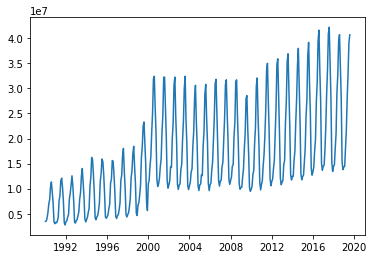

In [22]:
"""
What is being predicted on
"""
# Employment numbers
# tour_lfsq1r2 = load_tsv("tour_lfsq1r2.tsv", decode=True)
# print_unique_values(tour_lfsq1r2)
# y = select_by_dict(tour_lfsq1r2, {
#     "nace_r2": "Total - all NACE activities",
#     "wstatus": "Employees",
#     "worktime": "Part-time",
#     "unit": "Thousand",
# })
# y["time"] = y["time"].apply(string_encoding_to_datetime)
# y = y.dropna(axis=0, subset=["value"])
# y = y.set_index(["geo", "time"])
# plt.plot(y.xs("Spain", level="geo", drop_level=True).sort_index())

# Hotel stays
tour_occ_nim = load_tsv("tour_occ_nim.tsv", decode=True)
print_unique_values(tour_occ_nim)
y = select_by_dict(tour_occ_nim, {
    "c_resid": "Foreign country",
    "unit": "Number",
    "nace_r2": "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks",
})
y["time"] = y["time"].apply(string_encoding_to_datetime)
y = y.dropna(axis=0, subset=["value"])
y = y.set_index(["geo", "time"])
plt.plot(y.xs("Spain", level="geo", drop_level=True).sort_index())
y = y["value"]

In [23]:
y

geo                                                                                            time      
Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)  2019-12-01    50289864.0
European Union - 27 countries (2007-2013)                                                      2019-12-01    64664863.0
European Union - 28 countries                                                                  2019-12-01    65160780.0
Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)  2019-11-01    47407604.0
European Union - 27 countries (2007-2013)                                                      2019-11-01    64225379.0
                                                                                                                ...    
Liechtenstein                                                                                  1990-01-01       12762.0
Luxembourg                                            

In [24]:
from model_wrappers import NormalizingRegressionModel, SampleFilteringRegressionModel, ColumnFilteringRegressionModel
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [25]:
regressor = MLPRegressor(hidden_layer_sizes=(100, 50, 10), activation='relu', max_iter=5000, solver='adam')
# regressor = LinearRegression()
regressor = ColumnFilteringRegressionModel(regressor)
regressor = NormalizingRegressionModel(
    regressor,
    "scale"
)
regressor = SampleFilteringRegressionModel(regressor)
regressor.fit(x, y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 50, 10), learning_rate='constant',
             learning_rate_init=0.001, max_iter=5000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

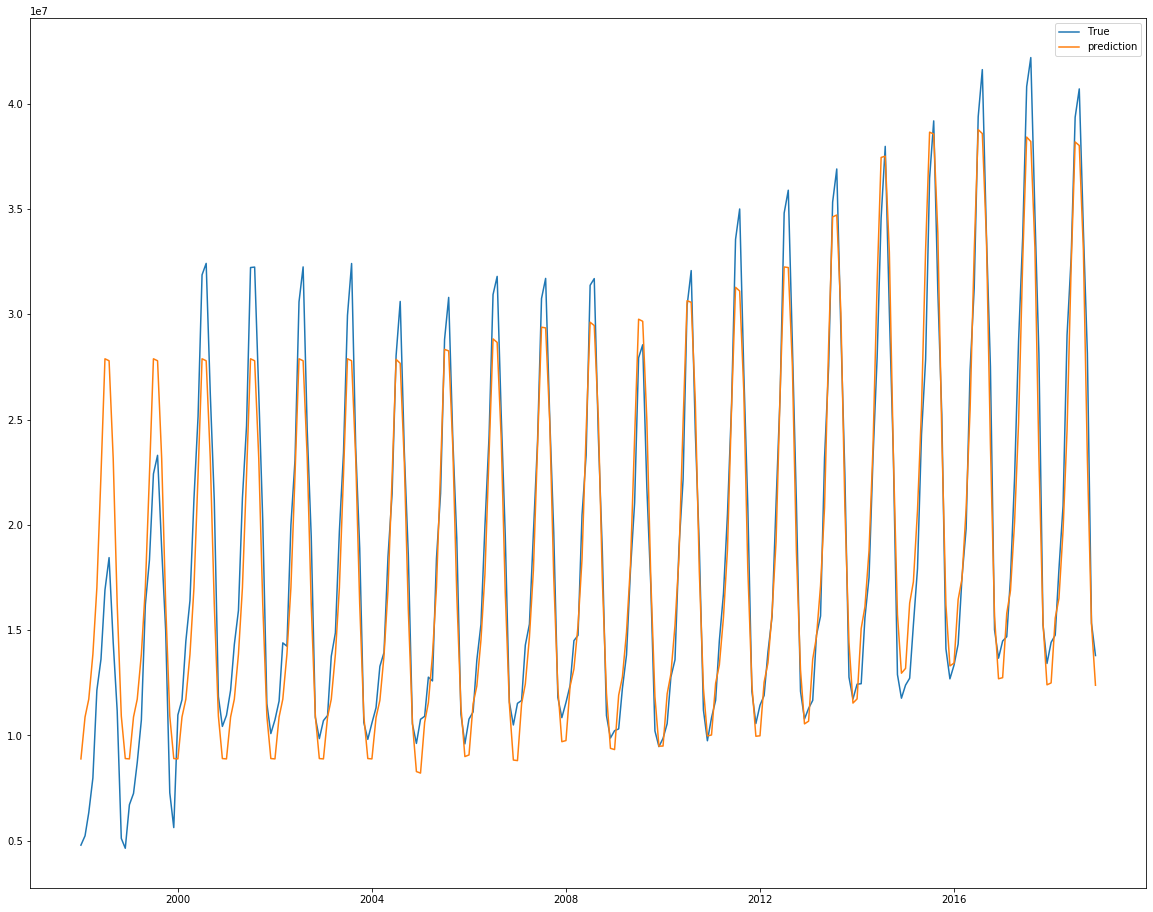

In [30]:
"""
Plot results
"""
ty = y.xs("Spain", level="geo", drop_level=False)
common_index = ty.index.intersection(x.index).sort_values()
ty = ty.loc[common_index]
plt.plot(ty.droplevel(0), label=True)
plt.plot(regressor.predict(x.loc[common_index, :]).droplevel(0), label="prediction")
plt.legend()
plt.show()

In [31]:
from feature_selection import get_features_by_score, forwards_recursive_feature_selection
from feature_selection import FeatureScoringFunctions, ModelScoringFunctions
ss = get_features_by_score(
    regressor, x, y,
    FeatureScoringFunctions.get_permutation_score(ModelScoringFunctions.internal_score)
)
for fs in ss:
    print("{1:.5f} {0}".format(fs[0], fs[1]))

0.62284 tas
0.74866 pr
0.83846 land_cover: Square kilometre; Common wheat
0.85540 land_cover: Square kilometre; Cherry fruit
0.86501 land_cover: Percentage; Wetland
0.86843 land_cover: Percentage; Other permanent crops
0.87036 land_cover: Square kilometre; Apple fruit
0.87933 land_cover: Square kilometre; Peatbogs
0.88219 land_cover: Coefficient of variation for absolute value; Non permanent industrial crops
0.88269 land_cover: Square kilometre; Dry pulses, vegetables and flowers
0.88376 land_cover: Square kilometre; Non built-up linear features
0.88564 land_cover: Coefficient of variation for absolute value; Greenhouses
0.88791 land_cover: Coefficient of variation for absolute value; Other fresh vegetables
0.88860 land_cover: Coefficient of variation for absolute value; Other citrus fruit
0.89082 land_cover: Coefficient of variation for absolute value; Triticale
0.89419 land_cover: Square kilometre; Other artificial areas
0.89458 land_cover: Percentage; Coniferous woodland
0.89876 pop

In [32]:
def create_model():
    regressor = MLPRegressor(hidden_layer_sizes=(100, 50, 10), activation='relu', max_iter=5000, solver='adam')
    # regressor = LinearRegression()
    regressor = ColumnFilteringRegressionModel(regressor)
    regressor = NormalizingRegressionModel(
        regressor,
        "scale"
    )
    regressor = SampleFilteringRegressionModel(regressor)
    return regressor

fbs = forwards_recursive_feature_selection(
    create_model,
    x,
    y,
    ModelScoringFunctions.internal_score,
    stop_after=20,
    minimize=False
)
for fs in fbs:
    print(fs)

Selected land_cover: Square kilometre; Buildings with more than 3 floors
Selected tas
Selected pop_over_18: Rural areas; Good; 65 years or over; Females
Selected land_cover: Percentage; Coniferous woodland
Selected land_cover: Percentage; Soya
Selected land_cover: Coefficient of variation for absolute value; Photo interpreted non permanent crops (B1x-B5x)
Selected land_cover: Square kilometre; Salines
Selected land_cover: Coefficient of variation for absolute value; Other fresh vegetables
Selected land_cover: Coefficient of variation for absolute value; Non built-up linear features
Selected pop_over_18: Cities; Bad; From 18 to 64 years; Females
Selected land_cover: Square kilometre; Olive groves
Selected land_cover: Coefficient of variation for absolute value; Oranges
Selected land_cover: Square kilometre; Dry pulses, vegetables and flowers
Selected land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops
Selected pr
Selected land_cover: Square kilo

In [33]:
for fs in fbs:
    print("{1:.5f} {0}".format(fs[0], fs[1]))

0.57401 land_cover: Square kilometre; Buildings with more than 3 floors
0.80428 tas
0.87106 pop_over_18: Rural areas; Good; 65 years or over; Females
0.91346 land_cover: Percentage; Coniferous woodland
0.92376 land_cover: Percentage; Soya
0.93688 land_cover: Coefficient of variation for absolute value; Photo interpreted non permanent crops (B1x-B5x)
0.93956 land_cover: Square kilometre; Salines
0.94065 land_cover: Coefficient of variation for absolute value; Other fresh vegetables
0.94242 land_cover: Coefficient of variation for absolute value; Non built-up linear features
0.94643 pop_over_18: Cities; Bad; From 18 to 64 years; Females
0.95165 land_cover: Square kilometre; Olive groves
0.95280 land_cover: Coefficient of variation for absolute value; Oranges
0.94994 land_cover: Square kilometre; Dry pulses, vegetables and flowers
0.95159 land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops
0.95215 pr
0.95696 land_cover: Square kilometre; Common wh

In [34]:
combined = set()
combined.update([x[0] for x in fbs])
combined.update([x[0] for x in ss][:30])
exclude = [col for col in x.columns if col not in combined]
exclude

['land_cover: Percentage; Tomatoes',
 'land_cover: Percentage; Bare land',
 'pop_over_18: Cities; Bad; 18 years or over; Females']

In [35]:
# FEM.save(exclude)